In [2]:
import numpy as np
import pandas as pd

from typing import List, Tuple
import matplotlib.pyplot as plt
import math

from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier


# Fix the random seed for reproducibility
# !! Important !! : do not change this
# hw1_seed = 1234
# np.random.seed(hw1_seed)  
# pd.options.mode.chained_assignment = None 

In [7]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296) 
  
# data (as pandas dataframes) 
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features 
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets 
  
# metadata 
print(diabetes_130_us_hospitals_for_years_1999_2008.metadata) 
  
# variable information 
print(diabetes_130_us_hospitals_for_years_1999_2008.variables) 

## testing splits ##

## 20 percent set aside
X_temp, X_te, y_temp, y_te = train_test_split(X, y, 
                                    test_size=0.20, random_state=1234, shuffle=True)

## that 75/25 split for the end 
X_tr, X_val, y_tr, y_val = train_test_split(X_temp, y_temp, 
                                    test_size=0.25, random_state=1234, shuffle=True)


X_tr



c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\ucimlrepo\fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


{'uci_id': 296, 'name': 'Diabetes 130-US Hospitals for Years 1999-2008', 'repository_url': 'https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008', 'data_url': 'https://archive.ics.uci.edu/static/public/296/data.csv', 'abstract': 'The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. Each row concerns hospital records of patients diagnosed with diabetes, who underwent laboratory, medications, and stayed up to 14 days. The goal is to determine the early readmission of the patient within 30 days of discharge.\nThe problem is important for the following reasons. Despite high-quality evidence showing improved clinical outcomes for diabetic patients who receive various preventive and therapeutic interventions, many patients do not receive them. This can be partially attributed to arbitrary diabetes management in hospital environments, which fail to attend to glycemic control. Failure to provide pro

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
48004,AfricanAmerican,Female,[60-70),NaN,1,1,7,2,NaN,NaN,...,No,No,Steady,No,No,No,No,No,Ch,Yes
66310,Caucasian,Male,[70-80),NaN,1,1,7,4,MC,NaN,...,No,No,No,No,No,No,No,No,No,Yes
60905,Caucasian,Female,[70-80),NaN,1,1,7,3,HM,NaN,...,No,No,Steady,No,No,No,No,No,Ch,Yes
1873,Caucasian,Female,[70-80),NaN,3,1,1,2,NaN,Surgery-General,...,No,No,No,No,No,No,No,No,No,No
38252,Caucasian,Female,[50-60),NaN,1,6,7,3,MD,InternalMedicine,...,No,No,No,No,No,No,No,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56803,AfricanAmerican,Male,[20-30),NaN,1,1,7,11,DM,NaN,...,No,No,Down,No,No,No,No,No,Ch,Yes
60682,Caucasian,Male,[70-80),NaN,1,6,1,7,NaN,Emergency/Trauma,...,No,No,Down,No,No,No,No,No,Ch,Yes
4596,Caucasian,Female,[70-80),NaN,1,3,7,4,NaN,Orthopedics,...,No,No,No,No,No,No,No,No,No,Yes
19756,AfricanAmerican,Male,[40-50),NaN,1,1,7,2,NaN,InternalMedicine,...,No,No,No,No,No,No,No,No,No,Yes


In [47]:
#rebecca 
#print(X_tr.dtypes)

def split_by_type(X):
    X_num = X.select_dtypes(include=['int64'])
    X_object = X.select_dtypes(include=['object'])
    return X_num, X_object

X_num, X_object = split_by_type(X_tr)
y_num, y_object = split_by_type(y_tr)
#print(X_num)
#print(X_object)

def summary_num(X):
    summary_table = []
    def get_mean(subset, col):
        return np.nanmean(subset[col], axis=0)
    def get_std(subset, col):
        return np.nanstd(subset[col], axis=0)
    def get_median(subset, col):
        return np.nanmedian(subset[col], axis=0)
    def get_var(subset, col):
        return np.nanvar(subset[col], axis=0)
    total_features = X.columns
    for col in total_features:
        summary_table.append([get_mean(X, col), get_std(X, col), get_median(X, col), get_var(X, col)])
    summary_table = np.to_array(summary_table)
    return summary_table

#print(summary_num(X_num))
    
    


C:\Users\16264\AppData\Local\Temp\ipykernel_12244\2722205601.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_tr[col].fillna(mode, inplace=True)
C:\Users\16264\AppData\Local\Temp\ipykernel_12244\2722205601.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

0.43544768175043813
0.4336952783373459


[Text(0.5, 0.8333333333333334, 'x[9] <= -0.11\ngini = 0.575\nsamples = 61059\nvalue = [6832, 21379, 32848]'),
 Text(0.25, 0.5, 'x[10] <= -0.995\ngini = 0.525\nsamples = 40455\nvalue = [3427, 12189, 24839]'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'gini = 0.45\nsamples = 9666\nvalue = [614.0, 2286.0, 6766.0]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.544\nsamples = 30789\nvalue = [2813, 9903, 18073]'),
 Text(0.75, 0.5, 'x[9] <= 0.675\ngini = 0.623\nsamples = 20604\nvalue = [3405, 9190, 8009]'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'gini = 0.603\nsamples = 11796\nvalue = [1518, 4918, 5360]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.628\nsamples = 8808\nvalue = [1887.0, 4272.0, 2649.0]')]

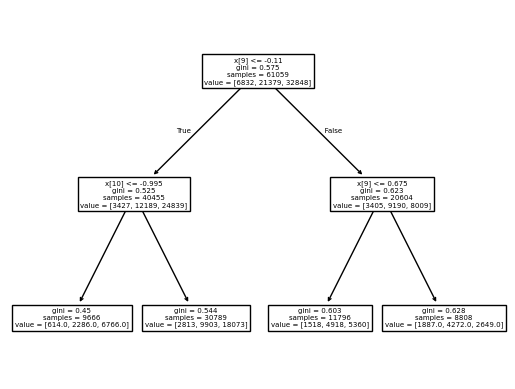

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#3 order ; one hot encoding <- splits categorical into more features 1/0 if yes/no and Standard scaler for scaling data


# replacing ? with NAN and replacing NAN with the mode
X = X.replace("?", np.nan)
y = y.replace("?", np.nan)

for col in X.columns:
    X[col] = X[col].fillna(X[col].mode()[0])


categorical = X_tr.select_dtypes(include=['object']).columns.tolist()
numerical = X_tr.select_dtypes(include=['int64']).columns.tolist()

encoder = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()

##### COL TRANSFORMER NUM AND CAT COLUMNS <- joins them tgt and applies scaler and encoder
preproc = ColumnTransformer(transformers = [('num', scaler, numerical), ('cat', encoder, categorical)])
X_tr_2 = preproc.fit_transform(X_tr)
X_val_2 = preproc.transform(X_val)
X_te_2 = preproc.transform(X_te)

hw1_seed = 1234
clf = DecisionTreeClassifier(max_depth=2, random_state=hw1_seed)
clf.fit(X_tr_2, y_tr)

clf_err_tr = 1-clf.score(X_tr_2, y_tr)
clf_err_val = 1-clf.score(X_val_2, y_val)

print(clf_err_tr)
print(clf_err_val)

plot_tree(clf)

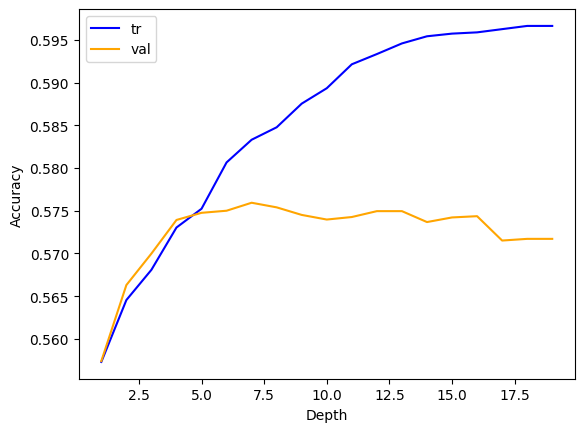

In [67]:
# decision tree w/ different max_depths
training_curve = []
testing_curve = []
max_depths = np.arange(1,20,1)
for depth in max_depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=hw1_seed, min_samples_leaf = 95)
    clf.fit(X_tr_2, y_tr)

    clf_acc_tr = clf.score(X_tr_2, y_tr)
    clf_acc_val = clf.score(X_val_2, y_val)
    training_curve.append(clf_acc_tr)
    testing_curve.append(clf_acc_val)
    
plt.plot(max_depths, training_curve, label='tr', color = 'blue')
plt.plot(max_depths, testing_curve, label='val', color = 'orange')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.legend()

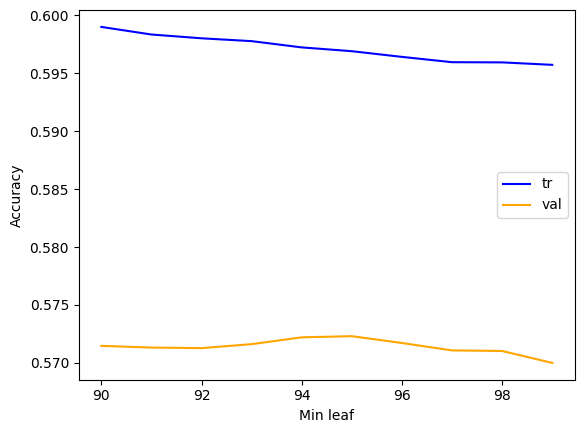

In [63]:
training_curve = []
testing_curve = []
min_leaf_samples = np.arange(90,100,1)
for min_leaf in min_leaf_samples:
    clf = DecisionTreeClassifier(criterion='gini', min_samples_leaf=min_leaf, random_state=hw1_seed)
    clf.fit(X_tr_2, y_tr)

    clf_acc_tr = clf.score(X_tr_2, y_tr)
    clf_acc_val = clf.score(X_val_2, y_val)
    training_curve.append(clf_acc_tr)
    testing_curve.append(clf_acc_val)
    
plt.plot(min_leaf_samples, training_curve, label='tr', color = 'blue')
plt.plot(min_leaf_samples, testing_curve, label='val', color = 'orange')
plt.xlabel('Min leaf')
plt.ylabel('Accuracy')
plt.legend()

C:\Users\16264\AppData\Local\Temp\ipykernel_12244\993415345.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_tr[col].fillna(mode, inplace=True)
C:\Users\16264\AppData\Local\Temp\ipykernel_12244\993415345.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when d

Best parameters: {'knn__metric': 'minkowski', 'knn__n_neighbors': 75, 'knn__weights': 'distance'}
Best CV accuracy: 0.5716273763999495
Validation Accuracy: 0.5742
Test Accuracy: 0.5697


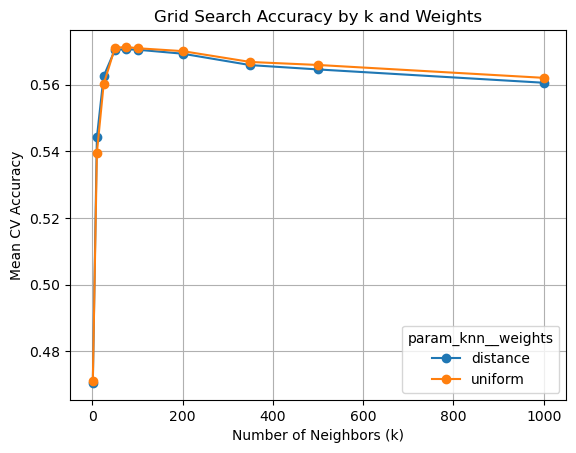

In [19]:
#amy

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD

#3 order ; one hot encoding <- splits categorical into more features 1/0 if yes/no and Standard scaler for scaling data


# replacing ? with NAN and replacing NAN with the mode

X_tr = X_tr.replace("?", np.nan)
X_val = X_val.replace("?", np.nan)
X_test = X_te.replace("?", np.nan)

for col in X_tr.columns:
    mode = X_tr[col].mode()[0]
    X_tr[col].fillna(mode, inplace=True)
    X_val[col].fillna(mode, inplace=True)
    X_test[col].fillna(mode, inplace=True)

categorical = X_tr.select_dtypes(include=['object']).columns.tolist()
numerical = X_tr.select_dtypes(include=['int64', 'float64']).columns.tolist()

preproc = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
])

X_tr_2 = preproc.fit_transform(X_tr)
X_val_2 = preproc.transform(X_val)
X_te_2 = preproc.transform(X_test)

pipeline = Pipeline(steps=[
    ('preprocessor', preproc),
    ('svd', TruncatedSVD(n_components=47, random_state=1234)),
    ('knn', KNeighborsClassifier())
])

test_params = {
    'knn__n_neighbors': [1, 10, 25,50,75, 100, 200, 350, 500, 1000],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski','euclidean', 'manhattan']
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=test_params,

)
grid_search.fit(X_tr, y_tr)
print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

best_model = grid_search.best_estimator_

val_preds = best_model.predict(X_val)
val_acc = accuracy_score(y_val, val_preds)
print(f"Validation Accuracy: {val_acc:.4f}")
test_preds = best_model.predict(X_te)
test_acc = accuracy_score(y_te, test_preds)
print(f"Test Accuracy: {test_acc:.4f}")


results_df = pd.DataFrame(grid_search.cv_results_)

pivot_table = results_df.pivot_table(
    index='param_knn__n_neighbors',
    columns='param_knn__weights',
    values='mean_test_score'
)

pivot_table.plot(kind='line', marker='o')
plt.title("Grid Search Accuracy by k and Weights")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean CV Accuracy")
plt.grid(True)
plt.show()


# svd = TruncatedSVD(n_components=47, random_state=1234)
# X_tr_svd = svd.fit_transform(X_tr_2)
# X_val_svd = svd.transform(X_val_2)
# X_te_svd = svd.transform(X_te_2)

# accs = []

# best_k = None
# best_acc = 0
# k_vals = [1, 10, 25,50,75, 100, 200, 350, 500, 1000] ## 1-50 = 7.5 mins, 1-1000+ = 11.5 mins

# for i, k in enumerate(k_vals):
#     print(k)
#     knn = KNeighborsClassifier(n_neighbors=k)

#     # knn.fit(X_tr_2, y_tr)
#     # pred = knn.predict(X_val_2)

#     ### SVD IMPLEMENTATION

#     knn.fit(X_tr_svd, y_tr)
#     pred = knn.predict(X_val_svd)
#     acc = accuracy_score(y_val, pred)

#     ####

#     accs.append(acc)

#     if acc > best_acc:
#         best_acc = acc
#         best_k = k
    # errs.append(1-acc)
## TODO: some of that ravel error stuff ? doesnt matter long run tho
# plt.plot(k_vals, accs, marker='o', label='Accuracy')
# plt.legend()
# plt.show()
# print("BEST K FOUND:", best_k, round(best_acc, 4))

Removing feature: race


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with race removed: 0.5741
Removing feature: gender


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with gender removed: 0.5746
Removing feature: age


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with age removed: 0.5739
Removing feature: weight


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with weight removed: 0.5750
Removing feature: admission_type_id


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with admission_type_id removed: 0.5735
Removing feature: discharge_disposition_id


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with discharge_disposition_id removed: 0.5695
Removing feature: admission_source_id


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with admission_source_id removed: 0.5738
Removing feature: time_in_hospital


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with time_in_hospital removed: 0.5765
Removing feature: payer_code


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with payer_code removed: 0.5750
Removing feature: medical_specialty


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with medical_specialty removed: 0.5737
Removing feature: num_lab_procedures


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with num_lab_procedures removed: 0.5747
Removing feature: num_procedures


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with num_procedures removed: 0.5752
Removing feature: num_medications


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with num_medications removed: 0.5738
Removing feature: number_outpatient


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with number_outpatient removed: 0.5709
Removing feature: number_emergency


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with number_emergency removed: 0.5726
Removing feature: number_inpatient


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with number_inpatient removed: 0.5626
Removing feature: diag_1


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with diag_1 removed: 0.5746
Removing feature: diag_2


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with diag_2 removed: 0.5737
Removing feature: diag_3


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with diag_3 removed: 0.5759
Removing feature: number_diagnoses


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with number_diagnoses removed: 0.5751
Removing feature: max_glu_serum


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with max_glu_serum removed: 0.5739
Removing feature: A1Cresult


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with A1Cresult removed: 0.5730
Removing feature: metformin


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with metformin removed: 0.5752
Removing feature: repaglinide


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with repaglinide removed: 0.5749
Removing feature: nateglinide


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with nateglinide removed: 0.5744
Removing feature: chlorpropamide


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with chlorpropamide removed: 0.5741
Removing feature: glimepiride


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with glimepiride removed: 0.5738
Removing feature: acetohexamide


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with acetohexamide removed: 0.5747
Removing feature: glipizide


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with glipizide removed: 0.5756
Removing feature: glyburide


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with glyburide removed: 0.5735
Removing feature: tolbutamide


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with tolbutamide removed: 0.5740
Removing feature: pioglitazone


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with pioglitazone removed: 0.5734
Removing feature: rosiglitazone


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with rosiglitazone removed: 0.5749
Removing feature: acarbose


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with acarbose removed: 0.5742
Removing feature: miglitol


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with miglitol removed: 0.5741
Removing feature: troglitazone


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with troglitazone removed: 0.5748
Removing feature: tolazamide


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with tolazamide removed: 0.5740
Removing feature: examide


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with examide removed: 0.5743
Removing feature: citoglipton


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with citoglipton removed: 0.5743
Removing feature: insulin


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with insulin removed: 0.5753
Removing feature: glyburide-metformin


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with glyburide-metformin removed: 0.5745
Removing feature: glipizide-metformin


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with glipizide-metformin removed: 0.5740
Removing feature: glimepiride-pioglitazone


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with glimepiride-pioglitazone removed: 0.5740
Removing feature: metformin-rosiglitazone


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with metformin-rosiglitazone removed: 0.5736
Removing feature: metformin-pioglitazone


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with metformin-pioglitazone removed: 0.5736
Removing feature: change


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with change removed: 0.5755
Removing feature: diabetesMed


c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


acc with diabetesMed removed: 0.5757


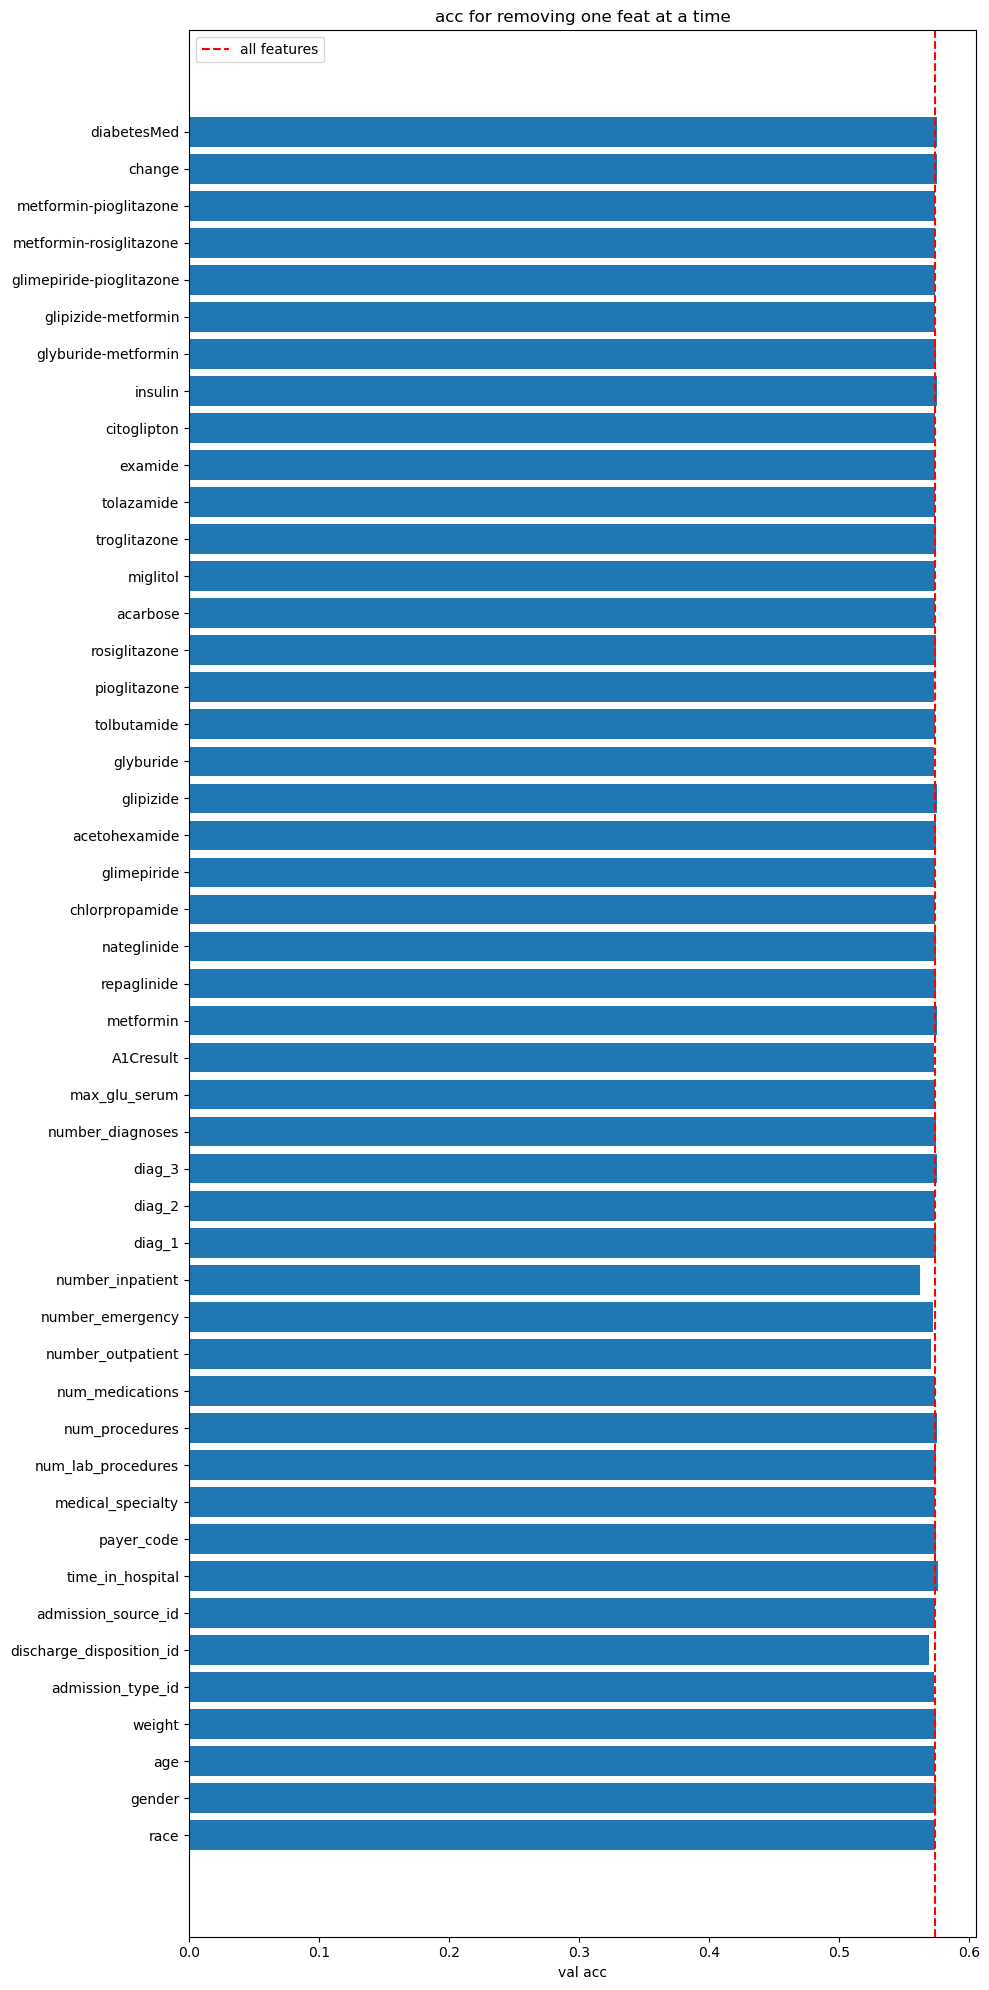

In [12]:
all_features = X_tr.columns.tolist()
accuracies = []
removed_features = []

for feature in all_features:
    print(f"Removing feature: {feature}")

    X_tr_drop = X_tr.drop(columns=[feature])
    X_val_drop = X_val.drop(columns=[feature])
    X_test_drop = X_test.drop(columns=[feature])

    cat = [col for col in X_tr_drop.select_dtypes(include=['object']).columns.tolist()]
    num = [col for col in X_tr_drop.select_dtypes(include=['int64', 'float64']).columns.tolist()]

    preproc = ColumnTransformer(transformers=[
        ('num', StandardScaler(), num),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat)
    ])

    X_tr_proc = preproc.fit_transform(X_tr_drop)
    X_val_proc = preproc.transform(X_val_drop)

    svd = TruncatedSVD(n_components=47, random_state=1234)
    X_tr_svd = svd.fit_transform(X_tr_proc)
    X_val_svd = svd.transform(X_val_proc)

    knn = KNeighborsClassifier(n_neighbors=best_k)

    knn.fit(X_tr_svd, y_tr)
    y_pred = knn.predict(X_val_svd)
    acc = accuracy_score(y_val, y_pred)

    print(f"acc with {feature} removed: {acc:.4f}")
    accuracies.append(acc)
    removed_features.append(feature)

plt.figure(figsize=(10, 20))
plt.barh(removed_features, accuracies)
plt.axvline(x=best_acc, color='r', linestyle='--', label='all features')
plt.xlabel("val acc")
plt.title("acc for removing one feat at a time")
plt.legend()
plt.tight_layout()
plt.show()

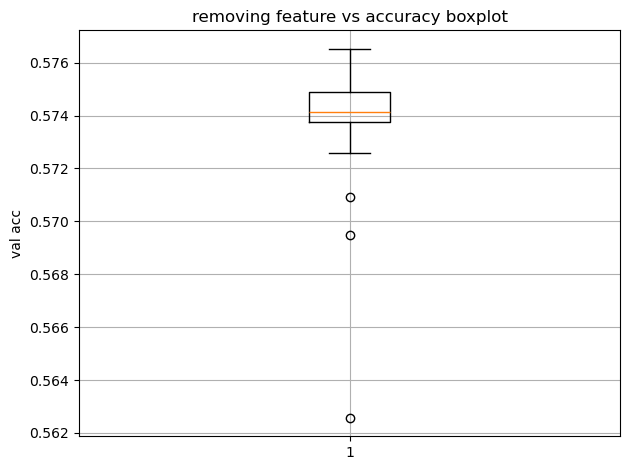

In [14]:
plt.boxplot(accuracies, vert=True)
plt.ylabel("val acc")
plt.title("removing feature vs accuracy boxplot")
plt.grid(True)
plt.tight_layout()
plt.show()

c:\Users\16264\miniconda3\envs\cs178\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Test Accuracy with best k (100): 0.5744

Classification Report:
               precision    recall  f1-score   support

         <30       0.46      0.01      0.02      2308
         >30       0.52      0.24      0.33      7106
          NO       0.59      0.91      0.71     10940

    accuracy                           0.57     20354
   macro avg       0.52      0.39      0.35     20354
weighted avg       0.55      0.57      0.50     20354



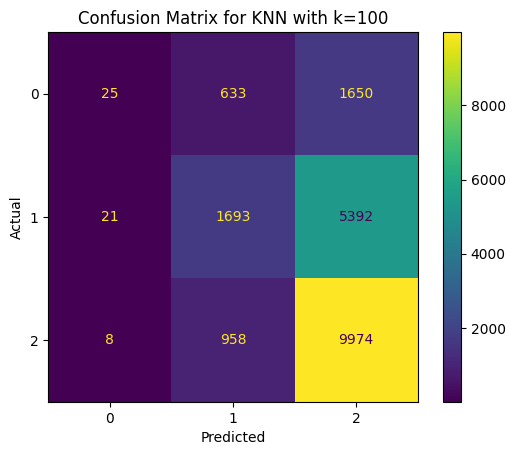

In [36]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def compute_confusion_matrix(y, y_pred):
    
    ### YOUR CODE STARTS HERE ###
    tp_labels = []
    conf_matrix = []
    for i in range(len(y)):
        tp_labels.append([y[i], y_pred[i]])
    #     conf_matrix.append([0 for j in range(len(y))])
    # print(conf_matrix)
    conf_matrix = np.zeros((10, 10), dtype=int)
    for y1, y2 in tp_labels:
        # print(y1, y2)
        # print(conf_matrix[y1][y2])
        conf_matrix[y1][y2] += 1
        
    ### YOUR CODE ENDS HERE ###
    return np.array(conf_matrix)

best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_tr_svd, y_tr)
y_pred_test = best_knn.predict(X_te_svd)

acc = accuracy_score(y_te, y_pred_test)
print("Test Accuracy with best k ({}): {:.4f}".format(best_k, acc))

conf_matrix = confusion_matrix(y_te, y_pred_test)
report = classification_report(y_te, y_pred_test)

print("\nClassification Report:\n", report)

disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)

disp.plot()
plt.title(f'Confusion Matrix for KNN with k={best_k}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [18]:
#varsh
#logistic regression
seed = 1234
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#3 order ; one hot encoding <- splits categorical into more features 1/0 if yes/no and Standard scaler for scaling data


# replacing ? with NAN and replacing NAN with the mode
X = X.replace("?", np.nan)
y = y.replace("?", np.nan)

for col in X.columns:
    X[col] = X[col].fillna(X[col].mode()[0])


categorical = X_tr.select_dtypes(include=['object']).columns.tolist()
numerical = X_tr.select_dtypes(include=['int64']).columns.tolist()

encoder = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()

##### COL TRANSFORMER NUM AND CAT COLUMNS <- joins them tgt and applies scaler and encoder
preproc = ColumnTransformer(transformers = [('num', scaler, numerical), ('cat', encoder, categorical)])
X_tr_2 = preproc.fit_transform(X_tr)
X_val_2 = preproc.transform(X_val)
X_te_2 = preproc.transform(X_te)

def logistic_classification(X, y): 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    #  set the state of the random number generator so that we get the same results across runs when testing our code

    ### YOUR CODE START HERE ### 

    # Specify the logistic classifier model
    # # Please use 'l1' penality type, 'liblinear' solver and enable fit_intercept
    classifier = LogisticRegression(penalty='l1', solver='liblinear', fit_intercept=True)
    # Train a logistic regression classifier and evaluate accuracy on the training data
    print('\nTraining a model with', X_train.shape[0], 'examples.....')
    # Training 
    classifier.fit(X_train, y_train)
    
    train_predictions = classifier.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_predictions)
    print('\nTraining accuracy:',format( 100*train_accuracy , '.2f') ) 

    # Compute and print accuracy on the test data
    test_predictions = classifier.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predictions)

    ### YOUR CODE ENDS HERE ###
    print('\nTesting accuracy:', format( 100*test_accuracy , '.2f') )

    return classifier, train_accuracy, test_accuracy


#feedforward neural network

def train_mlp_with_hyperparameters(hyper_params, X_tr_10k, y_tr_10k, X_val_10k, y_val_10k, X_te_scaled, y_te, seed) -> Tuple[float, float, float]:
    mlp = MLPClassifier(**hyper_params, shuffle=True, random_state=seed, verbose=False)
    mlp.fit(X_tr_10k, y_tr_10k)
    train_accuracy = mlp.score(X_tr_10k, y_tr_10k)
    val_accuracy = mlp.score(X_val_10k, y_val_10k)
    test_accuracy = mlp.score(X_te_scaled, y_te)
    
    print('Hyperparameters performance:')
    print(f'Training accuracy: {train_accuracy}')
    print(f'Validation accuracy: {val_accuracy}')
    print(f'Test accuracy: {test_accuracy}')
    return train_accuracy, val_accuracy, test_accuracy

best_hyperparams = {'hidden_layer_sizes': (100,),
                    'activation': 'relu', 
                    'solver': 'sgd',
                    'alpha': .1,
                    'learning_rate': 'constant',
                    'learning_rate_init': .05,
                    'max_iter': 100,
                    'n_iter_no_change': 1}

logistic_classification(X_tr_2, y_tr)
train_mlp_with_hyperparameters(best_hyperparams, X_tr_2, y_tr, X_val_2, y_val, X_te_2, y_te, seed)



Training a model with 42741 examples.....


c:\Users\Varshini\.anaconda\envs\cs178\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Training accuracy: 59.61

Testing accuracy: 57.31


c:\Users\Varshini\.anaconda\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1119: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Hyperparameters performance:
Training accuracy: 0.6121128744329255
Validation accuracy: 0.5872844298137867
Test accuracy: 0.5897120959025253


(0.6121128744329255, 0.5872844298137867, 0.5897120959025253)